# Imports 

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


# Load Dataset
WELFake from HuggingFace

In [3]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

Generating train split: 100%|██████████| 70793/70793 [00:00<00:00, 75800.34 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 70793
    })
})


## Split dataset

In [4]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
70788  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
70789  You know, because in fantasyland Republicans n...      1           0   
70790  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
70791  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   
70792  Goldman Sachs Endorses Hillary Clinton For Pre...      1           0   

       has_url  percent_uppercase  frequency_punctu

In [5]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df.drop(labels=["label", "text"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

       has_quotes  has_url  percent_uppercase  frequency_punctuation  \
33090           0        0           4.365983                     42   
13814           0        1           2.970607                     70   
47609           0        0           3.880804                     29   
30722           0        0           3.251016                     67   
1945            0        1           2.789491                     77   
...           ...      ...                ...                    ...   
12895           0        1           3.202995                     61   
60960           0        1           2.864939                     32   
6012            0        1          17.731959                     11   
63107           0        0           3.806452                     30   
6558            0        0           5.263158                      4   

       percent_whitespace  frequency_words_length_15  \
33090           16.362946                          0   
13814           16.8230

### Training

no further preprocessing

In [6]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [7]:
#instantiate with default params first
rf = RandomForestClassifier(random_state=seed)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=45)

In [8]:
y_pred = rf.predict(x_test)

In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.9091037502648492


## Visualize feature importance

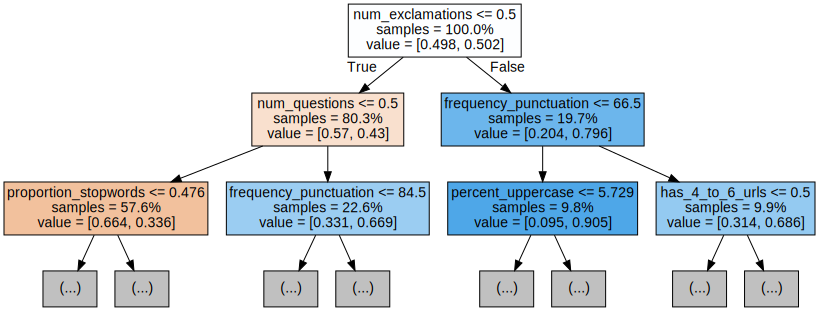

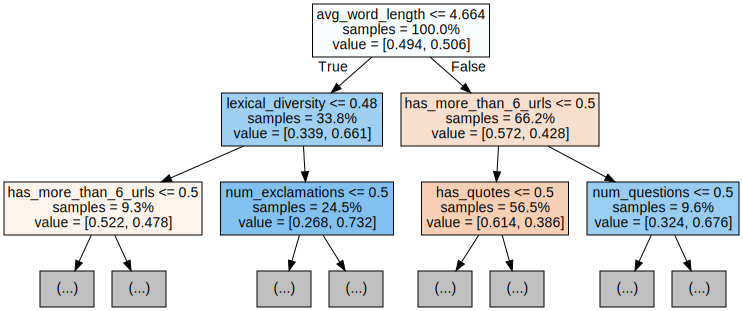

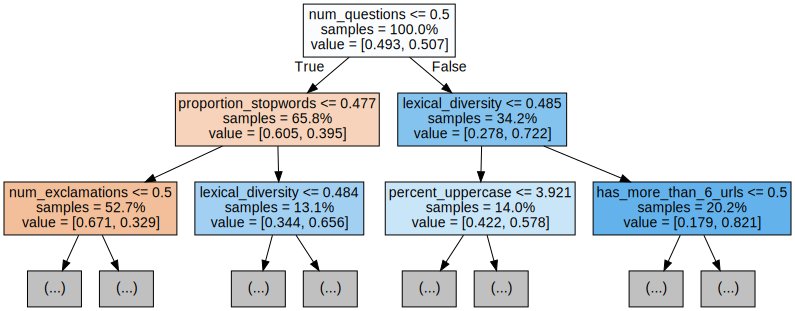

In [10]:
from sklearn.tree import export_graphviz
import graphviz

# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Cross Validation

## Hyperparameter tuning

In [11]:
#randomizedsearchcv - includes cross validation
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}


# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                 random_state=seed)

# Fit the random search object to the data
rand_search.fit(x_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A372641460>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A374078A40>},
                   random_state=45)

In [12]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 115}


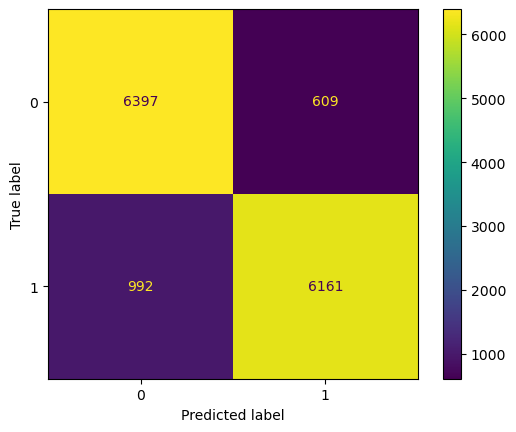

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
# Generate predictions with the best model
y_pred = best_rf.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [14]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8869270428702593
Precision: 0.9100443131462334
Recall: 0.8613169299594575


## Results on test set

In [15]:
test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test_Stylo")
print(test_dataset)

Generating train split: 100%|██████████| 6900/6900 [00:00<00:00, 80646.21 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 6900
    })
})


In [16]:
test_df = test_dataset["train"].to_pandas()
display(test_df)


y_test_set = test_df["label"]
x_test_set = test_df.drop(labels=["label", "text"], axis=1)

display(x_test_set)
display(y_test_set)

,text,label,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,The media reported on “5 TikTok dances you can...,0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,"""Over 240,000 'unverified' ballots have alread...",0,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,"Says ""Ron Johnson is making excuses for rioter...",1,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,“We have seen over the last 10 years ... under...,0,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,“I don’t get involved in the hiring and firing...,0,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


0       0
1       0
2       1
3       0
4       0
       ..
6895    0
6896    0
6897    0
6898    0
6899    0
Name: label, Length: 6900, dtype: int64

In [17]:
y_test_pred = best_rf.predict(x_test_set)

In [18]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4339130434782609
Precision: 0.2696135831381733
Recall: 0.39493996569468265


## Recursive Feature Elimination

In [21]:
from sklearn.feature_selection import RFE
import pandas as pd

def recursive_feature_pruning(model, x, y, num_features_to_select=None):

    rfe = RFE(estimator=model, n_features_to_select=num_features_to_select or 1, step=1)
    rfe.fit(x, y)

    # Get selected features
    selected_features = x.columns[rfe.support_]
    
    # Get ranking of features
    feature_ranking = pd.DataFrame({
        'feature': x.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')

    return selected_features.tolist(), feature_ranking


In [22]:
top_features, ranking_df = recursive_feature_pruning(best_rf, x_train, y_train, num_features_to_select=10)

print("Selected Top Features:")
print(top_features)

print("\nFeature Rankings:")
print(ranking_df)


Selected Top Features:
['has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'avg_sentence_length', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords']

Feature Rankings:
                      feature  rank
17       proportion_stopwords     1
1                     has_url     1
2           percent_uppercase     1
3       frequency_punctuation     1
4          percent_whitespace     1
15            avg_word_length     1
14              num_questions     1
13           num_exclamations     1
16          lexical_diversity     1
9         avg_sentence_length     1
8   frequency_words_length_11     2
12       has_more_than_6_urls     3
7   frequency_words_length_12     4
10            has_1_to_3_urls     5
11            has_4_to_6_urls     6
6   frequency_words_length_14     7
0                  has_quotes     8
5   frequency_words_length_15     9


## Train with top features after Recursive Feature Elimination

In [25]:
display(x_train[top_features])

,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,avg_sentence_length,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
33090,0,4.365983,42,16.362946,27.937500,0,0,5.108747,0.524823,0.442080
13814,1,2.970607,70,16.823014,19.551724,0,1,4.761029,0.529412,0.496324
47609,0,3.880804,29,16.770617,25.200000,0,0,4.966102,0.635593,0.457627
30722,0,3.251016,67,16.723976,17.718750,0,2,4.641441,0.533333,0.452252
1945,1,2.789491,77,16.477457,24.090909,0,0,4.785441,0.519157,0.440613
...,...,...,...,...,...,...,...,...,...,...
12895,1,3.202995,61,18.219634,21.857143,1,0,4.349315,0.531963,0.529680
60960,1,2.864939,32,17.189632,28.000000,0,1,4.720317,0.527704,0.480211
6012,1,17.731959,11,17.113402,14.833333,0,1,4.827160,0.777778,0.382716
63107,0,3.806452,30,17.161290,27.600000,0,0,4.551471,0.547794,0.477941


In [26]:
rand_search.fit(x_train[top_features], y_train)

best_rf_rfe = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 115}


In [27]:
y_pred_rfe = best_rf_rfe.predict(x_test[top_features])

In [28]:
accuracy = accuracy_score(y_test, y_pred_rfe)
precision = precision_score(y_test, y_pred_rfe)
recall = recall_score(y_test, y_pred_rfe)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8760505685429762
Precision: 0.8963289280469897
Recall: 0.8533482454914022


### Results on test set

In [29]:
y_test_rfe = best_rf_rfe.predict(x_test_set[top_features])

In [31]:
accuracy = accuracy_score(y_test_set, y_test_rfe)
precision = precision_score(y_test_set, y_test_rfe)
recall = recall_score(y_test_set, y_test_rfe)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.42536231884057973
Precision: 0.27997844246833736
Recall: 0.44554030874785594


# save model

In [32]:
import pickle

pickle.dump(best_rf_rfe, open("models/iter2_rf_rfe", 'wb'))

Results are a lot worse for test set compared to validation set - shows that random forest model overfit to the training data. 

Do randomsearch again, but reduce model complexity.

In [ ]:
# #test to see if model can be loaded

# loaded_model = pickle.load(open('models/iter2_rf_rfe', 'rb'))

# load_predict = loaded_model.predict(x_test_set)

# accuracy = accuracy_score(y_test_set, load_predict)
# precision = precision_score(y_test_set, load_predict)
# recall = recall_score(y_test_set, load_predict)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)

Accuracy: 0.4339130434782609
Precision: 0.2696135831381733
Recall: 0.39493996569468265
